In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
## Visualizing reconstructions
def vis(images, save_name):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_name + '_vis.png')

In [3]:
mnist_width = 28
n_visible = mnist_width * mnist_width
n_hidden = 500
corruption_level = 0.3

# create node for input data
X = tf.placeholder("float", [None, n_visible], name='X')

# create node for corruption mask
mask = tf.placeholder("float", [None, n_visible], name='mask')

# create nodes for hidden variables
W_init_max = 4 * np.sqrt(6. / (n_visible + n_hidden))
W_init = tf.random_uniform(shape=[n_visible, n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]), name='b')

W_prime = tf.transpose(W)  # tied weights between encoder and decoder
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')


def model(X, mask, W, b, W_prime, b_prime):
    tilde_X = mask * X  # corrupted X

    Y = tf.nn.sigmoid(tf.matmul(tilde_X, W) + b)  # hidden state
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)  # reconstructed input
    return Z

# build model graph
Z = model(X, mask, W, b, W_prime, b_prime)

# create cost function
cost = tf.reduce_sum(tf.pow(X - Z, 2))  # minimize squared error
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)  # construct an optimizer
predict_op = Z
# load MNIST data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(100):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            input_ = trX[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, teX.shape)
        print(i, sess.run(cost, feed_dict={X: teX, mask: mask_np}))
    # save the predictions for 100 images
    mask_np = np.random.binomial(1, 1 - corruption_level, teX[:100].shape)
    predicted_imgs = sess.run(predict_op, feed_dict={X: teX[:100], mask: mask_np})
    input_imgs = teX[:100]

0 108406.0
1 92042.0
2 89249.0
3 82713.2
4 78151.4
5 74390.8
6 72015.9
7 71828.3
8 69332.3
9 68731.8
10 68145.3
11 68265.3
12 67235.4
13 65898.5
14 64715.7
15 65959.1
16 64296.7
17 64357.2
18 64036.3
19 63929.8
20 63378.2
21 62898.3
22 63187.5
23 62317.1
24 61670.0
25 61715.8
26 62116.4
27 62795.0
28 61892.8
29 61389.8
30 60549.2
31 61370.4
32 61048.0
33 60078.5
34 61084.6
35 60799.6
36 60013.3
37 59270.2
38 60399.1
39 59579.4
40 59688.3
41 59906.0
42 59644.6
43 58711.6
44 59510.8
45 58618.7
46 59926.5
47 61295.9
48 58731.6
49 58401.3
50 58328.6
51 58471.5
52 59144.1
53 59123.6
54 58675.9
55 58525.1
56 58359.7
57 58315.0
58 58468.3
59 59491.7
60 59006.0
61 59025.6
62 58651.7
63 57835.4
64 58771.6
65 58160.7
66 58898.3
67 57135.9
68 57846.8
69 58434.8
70 56996.6
71 57561.6
72 58196.5
73 56528.1
74 57455.5
75 57446.6
76 57333.2
77 58351.2
78 57662.7
79 57110.6
80 56629.7
81 58474.1
82 57532.4
83 56815.6
84 57185.8
85 57012.6
86 56752.7
87 56303.9
88 57389.8
89 56905.0
90 56485.3
91 57808

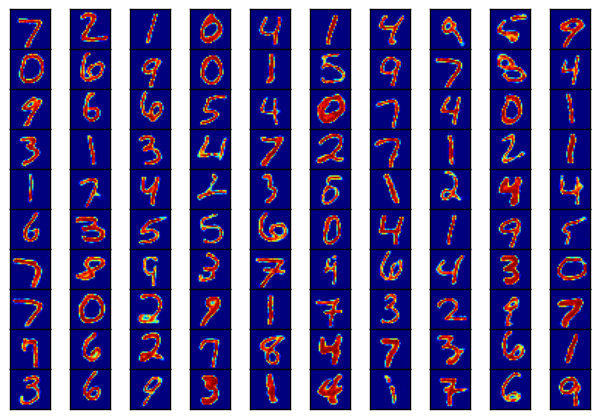

In [5]:
# Plot the reconstructed images
vis(predicted_imgs,'pred')

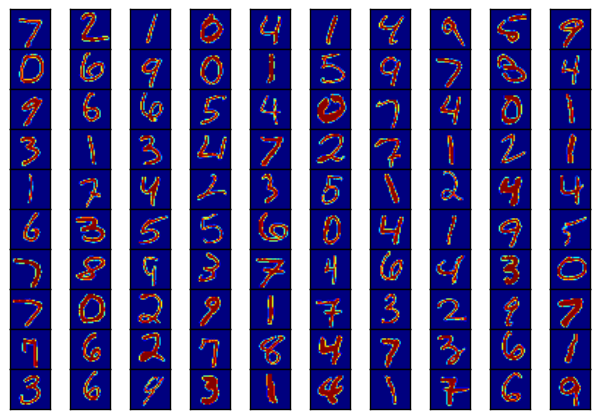

In [6]:
# Plot input images to compare with
vis(input_imgs,'in')